Berikut merupakan library yang digunakan pada script ini:
-> Digunakan numpy untuk mengolah data karena Numpy menyediakan fungsi yang siap pakai untuk memudahkan kita melakukan perhitungan saintifik seperti matriks, aljabar, statistik, dan sebagainya.

-> Pandas digunakan untuk mengolah data menjadi bentuk tabular.

-> Matplotlib digunakan untuk melakukan visualisasi data.

-> Digunakan scipy untuk melakukan FFT

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from tqdm.notebook import tqdm

In [3]:

#Fucntion for import data
for dirname, _, filenames in os.walk('Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Dataset/Healthy/h30hz80.csv
Dataset/Healthy/h30hz10.csv
Dataset/Healthy/h30hz90.csv
Dataset/Healthy/h30hz20.csv
Dataset/Healthy/h30hz40.csv
Dataset/Healthy/h30hz60.csv
Dataset/Healthy/h30hz50.csv
Dataset/Healthy/h30hz70.csv
Dataset/Healthy/h30hz30.csv
Dataset/Healthy/h30hz0.csv
Dataset/BrokenTooth/b30hz20.csv
Dataset/BrokenTooth/b30hz10.csv
Dataset/BrokenTooth/b30hz40.csv
Dataset/BrokenTooth/b30hz90.csv
Dataset/BrokenTooth/b30hz80.csv
Dataset/BrokenTooth/b30hz70.csv
Dataset/BrokenTooth/b30hz50.csv
Dataset/BrokenTooth/b30hz0.csv
Dataset/BrokenTooth/b30hz60.csv
Dataset/BrokenTooth/b30hz30.csv


In [4]:
dfs = []
for dirname, _, filenames in tqdm(os.walk('Dataset')):
    for filename in tqdm(filenames, leave=False):
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load
        
        # append to a list
        dfs.append(df)

# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
sensor_readings = df.melt(
    id_vars=['sample_index','state','load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)

In [6]:
# helper function to filter the dataset
def rdg(df, state=None, load=None, sensor=None):
    df_st = df[df.state==state] if state is not None else df
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    return df_se

## Frequency Analysis

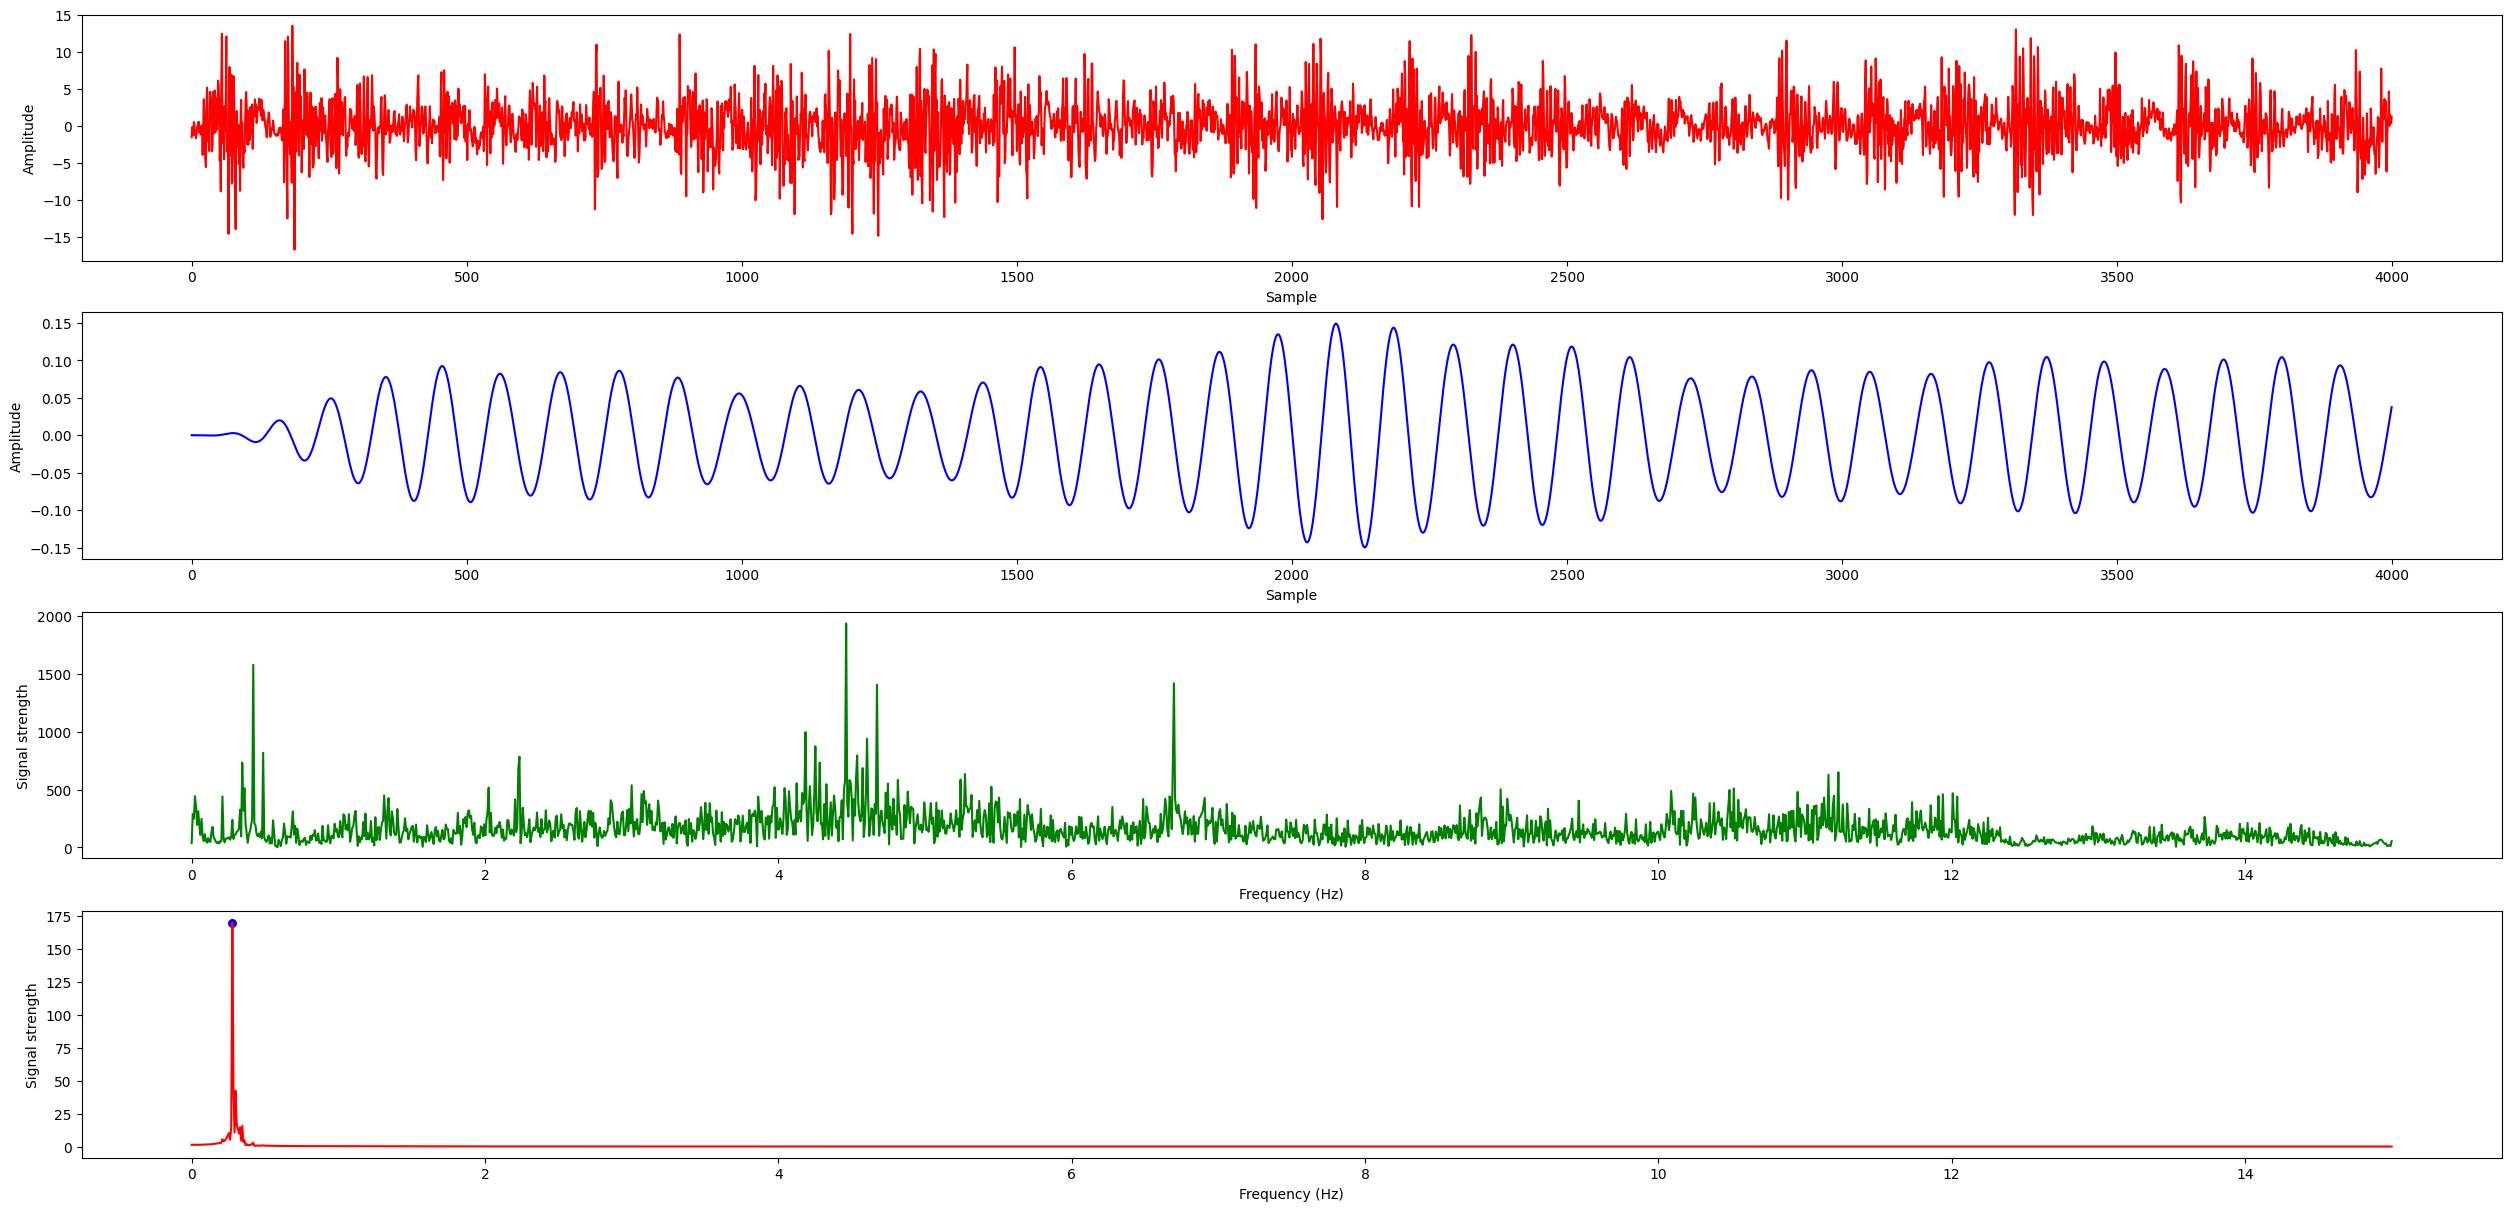

In [23]:
import scipy.signal

x = rdg(sensor_readings, 'h', 10, 'a4').reading.values[:4000]

b, a = scipy.signal.butter(3, [0.018,0.02],  btype='bandpass')
x_filtered = scipy.signal.lfilter(b, a, x)

y_nf = np.abs(fft.rfft(x))
x_nf = fft.rfftfreq(x.shape[0], 1/30) 

y_fft = np.abs(fft.rfft(x_filtered))
x_fft = fft.rfftfreq(x_filtered.shape[0], 1/30)  # 30Hz data rate

# find peaks that are
#   at least 1Hz apart (number of frequency points / max frequency)
x_peak_spacing = y_fft.shape[0] / x_fft.max()
#   rising above surrounding values by the 99th percentile of the values
x_peak_prominence = np.quantile(y_fft,0.99)

abnormal_peaks, _ = signal.find_peaks(y_fft, distance=x_peak_spacing, prominence=x_peak_prominence)



fig, ax = plt.subplots(4,1, figsize=(25,12), constrained_layout = True)
ax[0].plot(x, color='red')
ax[1].plot(x_filtered, color='blue')
ax[2].plot(x_nf, y_nf, color='green')
ax[3].plot(x_fft, y_fft, color='red')
for peak in abnormal_peaks:
    ax[3].scatter(x=x_fft[peak], y=y_fft[peak], c='b', marker='o', s=30)

for xz in range(4):
    if xz < 2:
        ax[xz].set_xlabel('Sample')
        ax[xz].set_ylabel('Amplitude')
    else:
        ax[xz].set_xlabel('Frequency (Hz)')
        ax[xz].set_ylabel('Signal strength')
plt.show()

## Neural Network Classification

In [ ]:
#SEKTALA BOLOO SABARRRRRRRRRRRR